In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy import wcs

(array([250290.,   3181.,   2011.,   1501.,   1206.,    997.,    874.,
           776.,    683.,    625.]),
 array([3.87579522e-04, 1.00334648e-01, 2.00281717e-01, 3.00228785e-01,
        4.00175854e-01, 5.00122922e-01, 6.00069991e-01, 7.00017059e-01,
        7.99964128e-01, 8.99911196e-01, 9.99858265e-01]),
 <a list of 10 Patch objects>)

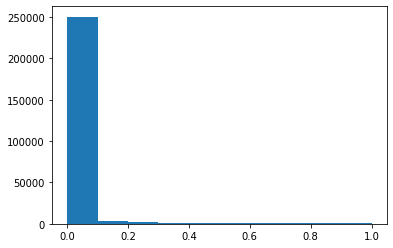

In [2]:
#open the primary beam fits file
primary_beam = fits.open("muellerbeam.fits")[0].data[0,0,0,:,:]
plt.hist(primary_beam.flatten())

In [3]:
#open the GLEAM catalog fits file
gleam_hdu = fits.open('asu.fit')
gleam_data = gleam_hdu[2].data

In [4]:
#let's trim the files we'll need
hera_resid_hdu = fits.open('deconvolved_3000_True_0.fits')
hera_resid = hera_resid_hdu[0].data

#use wcs solution to determine cutoff
w = wcs.WCS(hera_resid_hdu[0].header,naxis=2)

Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [5]:
def effective_intensity(ra, dec, intensity):
    
    # get primary beam at each source
    pbx, pby = np.array(w.all_world2pix(ra, dec, 0)).astype(int)
    pb_inb = np.logical_and.reduce(
        (pbx >= 0, pby >= 0, pbx < 512, pby < 512))
    pb = primary_beam[pbx * pb_inb, pby * pb_inb] * pb_inb
    return intensity * pb 


def within_bounds(ra, dec, intensity, min_brightness):
    return effective_intensity(ra, dec, intensity) > min_brightness

In [6]:
minb = 0.5 #min effective brightness (Jy)

in_bounds = gleam_data[within_bounds(gleam_data['RAJ2000'], gleam_data['DEJ2000'], gleam_data['Fintwide'], minb)]

# additional sources not in GLEAM [intensity, ra, dec]
fornax = np.array([[(3 + 24         /60)/24 * 360, -(37 + 16/60), 260],
                   [(3 +(21 + 40/60)/60)/24 * 360, -(37 + 10/60), 490],
                   [(3 +(22 + 43/60)/60)/24 * 360, -(37 +(12+2/60)/60), 2]])
f_inb = fornax[within_bounds(*fornax.T, minb)]

In [7]:
make_circles = lambda d : ["circle[[{}deg, {}deg], 0.5deg]\n".format(
                                    str(x[0]), str(x[1])) for x in d]
!rm -f "masks.txt"
mask_file = open("masks.txt", "w")
mask_file.write("#CRTFv0\n")
mask_file.writelines(make_circles(in_bounds) + make_circles(f_inb))
mask_file.close()